In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import integrate
import sys
sys.path.insert(1, '/Users/bnash/Downloads/Covid19Modeling-master3/data_processing')
import os
from load_CA_data import *
from scipy.optimize import fmin
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import lmfit 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

print(sys.path)

['/Users/bnash/Downloads/E25Bio_v0', '/Users/bnash/Downloads/Covid19Modeling-master3/data_processing', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python38.zip', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/lib-dynload', '', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages', '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/extensions', '/Users/bnash/.ipython']


In [13]:
def series_interp(data = []):
    y = [k for k in data if k >= 0]
    x = [i for i in range(len(data)) if data[i] >= 0 ]
    if 0 not in x:
        y = [0] + y
        x = [0] + x
    f = interp1d(x,y,kind='quadratic')
    return [data[i] if data[i] >= 0 else f(i) for i in range(len(data))]

def window_avg(data = [], window = 7):
    avg = []
    for i in range(len(data)):
        if i < window:
            avg.append(np.mean(data[:i+1]))
        else:
            avg.append(np.mean(data[i-window+1:i+1]))
    return avg

# Used for saving all plots to one pdf
import matplotlib.backends.backend_pdf
# plot output directory
outDir = '../'
# Geographical location of analysis 
place = 'CA_COUNTIES'
# pdf = matplotlib.backends.backend_pdf.PdfPages(outDir+"/covid_" + place + ".pdf")

cd = load_counties( '/Users/bnash/Downloads/Covid19Modeling-master3/data/CA/raw/')
cases_tot,hosp_total,deaths_tot,pops = {},{},{},{}

sdate = '04/10/2020' 
edate = '07/22/2020'

region_pop = np.sum([cd[county]['pop'] for county in cd.keys()])
total_included_pop = 0

for county in list(cd.keys()):
    #if county not in ["Placer","Stanislaus"] : continue
    DATA = {'cases': cd[county]['cases'], 'hosp':cd[county]['hosp'], 'deaths':cd[county]['deaths']}

    pop = cd[county]['pop'] 
    dates = DATA['cases']['date'][DATA['cases']['date'].index(sdate):DATA['cases']['date'].index(edate)]
    dates = [datetime.strptime(i,"%m/%d/%Y").date() for i in dates]
    ct = np.array(DATA['cases']['cases_pos_tot'])[DATA['cases']['date'].index(sdate):DATA['cases']['date'].index(edate)] / pop
    ht = np.array(DATA['hosp']['hosp_tot_today'])[DATA['hosp']['date'].index(sdate):DATA['hosp']['date'].index(edate)] / pop
    dt = np.array(DATA['deaths']['death_conf_tot'])[DATA['deaths']['date'].index(sdate):DATA['deaths']['date'].index(edate)] / pop

    # Selections on data sets
    if pop/region_pop < 0.015: continue 
    if not any(c>0.0 for c in dt): continue
    total_included_pop += pop

    # Save the data sets passing selection
    pops[county] = pop
    cases_tot[county]  = window_avg(series_interp(ct))
    hosp_total[county] = window_avg(series_interp(ht))
    deaths_tot[county] = window_avg(series_interp(dt))

# Check how much of population is used
print("Percentage of California population used: {}".format(total_included_pop/region_pop))

Percentage of California population used: 0.9244730094220871


In [14]:
# ratio undetected/detected infected (I/D)
phi = 11
# ratio of transmition rate for detected / undetected
eta_to_alpha = 0.01
# link Quarantine Undetected to S
q_time = 14.0
psi = 1/q_time
print(psi)
# Link Undetected Infected to Recovered
ud_time_recov = 14.0
lambd = 1/ud_time_recov
# Link Detected Infected to Hospitalized
d_time_recov = 14.0
rho = 1/d_time_recov
# Link Hospitalized to Recovered
hosp_los_recov = 14.0
sigma = 1/hosp_los_recov
# Used to Link Hospitalized to Dead
hosp_los_fat = 10.0
hosp_fat_rate = 0.346
tau = hosp_fat_rate/hosp_los_fat
# Ratio of infected detected to recovered
rRD = 2.0

def funct(y,par,dt=1.0,thresh=0.0,p=2.0):

    # Load parameter values
    S,Qu,I,D,H,R,QR,E,tot,total = y
    # Fit varying parameter values
    #beta = par['beta'].value
    alpha = par['alpha'].value
    eta   = eta_to_alpha*alpha
    eps   = par['eps'].value
    mu    = par['mu'].value
    tau   = par['tau'].value
    nu    = par['nu'].value
    # testing features
    freq = par['freq'].value
    sensitivity = par['sens'].value
    specificity = par['spec'].value
    if freq == -1.0:
        if D <= thresh:
            freq = 1/(p*np.log2(thresh/D)+1) # D = thresh*(1/2)^((a-1)/2)
        else:
            freq = 1.0
        eps = freq*sensitivity
    if freq != -1.0 and freq*sensitivity != 0:
        eps = freq*sensitivity
    if sensitivity != 0:
        nu *= sensitivity
        
    # link S to Quarantine Undetected
    gamma = freq*(1-specificity)
    
    if(round(S + Qu + I + D + H + R + QR + E) != 1.0): 
        print("Population not conserved")
        print([s for s in y])
        
    
    
    for k in range(100):
        dt = 1/100
        Sn   = S   + dt*(-eta*S*D            - alpha*S*I       - gamma*S         + psi*Qu)
        Qun  = Qu  + dt*(gamma*S             - psi*Qu)
        totn = tot + dt*((nu)*I)
        In   = I   + dt*(-(eps+nu+lambd)*I   + eta*S*D         + alpha*S*I)
        Dn   = D   + dt*((eps+nu)*I          - rho*D           - mu*(I+D))
        Hn   = H   + dt*(mu*(I+D)            - (sigma+tau)*H)
        Rn   = R   + dt*(rho*D               + lambd*I         + sigma*H         - gamma*R       + psi*QR)
        QRn  = QR  + dt*(gamma*R             - psi*QR)
        En   = E   + dt*(tau*H)
        totaln = total + dt*(eta*S*D         + alpha*S*I)
        S, Qu, I, D, H, R, QR, E, tot,total = Sn, Qun, In, Dn, Hn, Rn, QRn, En, totn,totaln

    return [S, Qu, I, D, H, R, QR, E, tot,total]

def resid(par,y=[],tot=[],H=[],E=[],Phi=[],window=1):
    Sn, Qun, In, Dn, Hn, Rn, QRn, En, totn, totaln = funct(y,par)
    residual = []
    for r in range(window):
        residual += list([(tot[r] - totn)/(tot[r]+10**-50), (H[r] - Hn)/(H[r]+10**-50), (E[r] - En)/(E[r]+10**-50), (0.017 - (Hn)/(In+Dn+Hn+10**-50))/0.017])
        y = [Sn, Qun, In, Dn, Hn, Rn, QRn, En, totn,totaln]
        Sn, Qun, In, Dn, Hn, Rn, QRn, En, totn, totaln = funct(y,par)
    residual = np.array(residual)
    #print(residual)
    return residual.ravel()

def get_PD(window=1,county="Los Angeles"):

    PD = {'beta':[],'alpha':[],'eps':[],'mu':[],'nu':[],'tau':[],'chisqr':[],'S':[],'Qu':[],'I':[],'D':[],'H':[],'R':[],'QR':[],'E':[],'tot':[],'total':[]}
    i = 0

    while i < len(cases_tot[county])-window:
        if i == 0:
            Qu0 = 0
    #         I0 = 30*cases_tot[i]
            D0 = cases_tot[county][i]
            H0 = hosp_total[county][i]
            R0 = rRD*cases_tot[county][i]
            QR0 = 0
            E0 = deaths_tot[county][i]
            I0 = (H0-0.017*(H0+D0))/(0.017)
            print(I0,'init',county)
            S0 = 1 - Qu0 - I0 - D0 - H0 - R0 - QR0 - E0
            tot0 = D0
            total0 = I0 + D0

            prev_step = [S0, Qu0, I0, D0, H0, R0, QR0, E0, tot0,total0]
            PD['S'].append(S0)
            PD['Qu'].append(Qu0)
            PD['I'].append(I0)
            PD['D'].append(D0)
            PD['H'].append(H0)
            PD['R'].append(R0)
            PD['QR'].append(QR0)
            PD['E'].append(E0)
            PD['tot'].append(tot0)
            PD['total'].append(total0)
                
        if i > 0:
            prev_step = [PD['S'][-1],PD['Qu'][-1],PD['I'][-1],PD['D'][-1],PD['H'][-1],PD['R'][-1],PD['QR'][-1],PD['E'][-1],PD['tot'][-1],PD['total'][-1]]
            
        params = lmfit.Parameters()
        #params.add('beta'  , 1.00  , min=0.5, max=2.5  )
        params.add('alpha' , 0.1         , min=0.01, max=0.7 )
        params.add('eps'   , 0.0          , vary=False        )
        params.add('nu'    , 0.17       , min=0.0005,max=1.0 )
        params.add('mu'    , 0.008        , min=0.0,max=1.0 )
        params.add('tau'   , 0.05       , min=0.0, max=1.0  )
        params.add('freq'  , 0.0          , vary=False        )
        params.add('sens'  , 0.0          , vary=False        )
        params.add('spec'  , 0.0          , vary=False        )   
        
        
        result = lmfit.minimize(resid, params, args=(prev_step, cases_tot[county][i+1:i+1+window], hosp_total[county][i+1:i+1+window], deaths_tot[county][i+1:i+1+window], [phi for p in range(window)], window),method='leastsq',**{'max_nfev':10000,'epsfcn':1e-7})
    #     result = lmfit.minimize(resid, params, args=(prev_step, cases_tot[i+1], hosp_total[i+1], deaths_tot[i+1], phi, window),method='least_squares',**{'max_nfev':50000})
        #PD['beta'].append(result.params['beta'])
        
        # evaluate model
        for p in range(window):
            if len(PD['S']) < len(cases_tot[county]):
                S,Qu,I,D,H,R,QR,E,tot,total = funct(prev_step,result.params)
                #print(cases_tot[i+1],tot,hosp_total[i+1],H,deaths_tot[i+1],E)
                PD['S'].append(S)
                PD['Qu'].append(Qu)
                PD['I'].append(I)
                PD['D'].append(D)
                PD['H'].append(H)
                PD['R'].append(R)
                PD['QR'].append(QR)
                PD['E'].append(E)
                PD['tot'].append(tot)
                PD['total'].append(total)
                PD['alpha'].append(result.params['alpha'])
                PD['nu'].append(result.params['nu'])
                PD['mu'].append(result.params['mu'])
                PD['tau'].append(result.params['tau'])
                PD['chisqr'].append(result.chisqr)
                prev_step = [S,Qu,I,D,H,R,QR,E,tot,total]
        i += window
    return PD


def run_avg(x, wind=1):
    avg = []
    for i in range(len(x)):
        if i >= np.floor(wind/2) and i < np.ceil(len(x) - wind/2):
            avg.append(np.mean(x[int(i+np.floor(-wind/2+1)):int(i+np.floor(wind/2+1))]))
        elif i < wind/2:
            avg.append(np.mean(x[:int(i+wind/2+1)]))
        else:
            avg.append(np.mean(x[int(i-wind/2+1):]))
    return avg


window=7
county_fits = {}
for county in cases_tot.keys():
    county_fits[county] = get_PD(county=county,window=window)

0.07142857142857142
0.005251544623188739 init Alameda
0.003749370684245136 init Fresno
0.0042584559779197265 init Kern
0.010989792805510781 init Los Angeles
0.004512309720953084 init Orange
0.0038707998556451765 init Sacramento
0.01160478227440943 init San Bernardino
0.005623928554626027 init San Diego
0.007688605344616324 init San Francisco
0.0029553469466637476 init San Joaquin
0.005148003184525636 init Santa Clara
0.0044369216832848704 init Stanislaus
0.006150352709221503 init Ventura


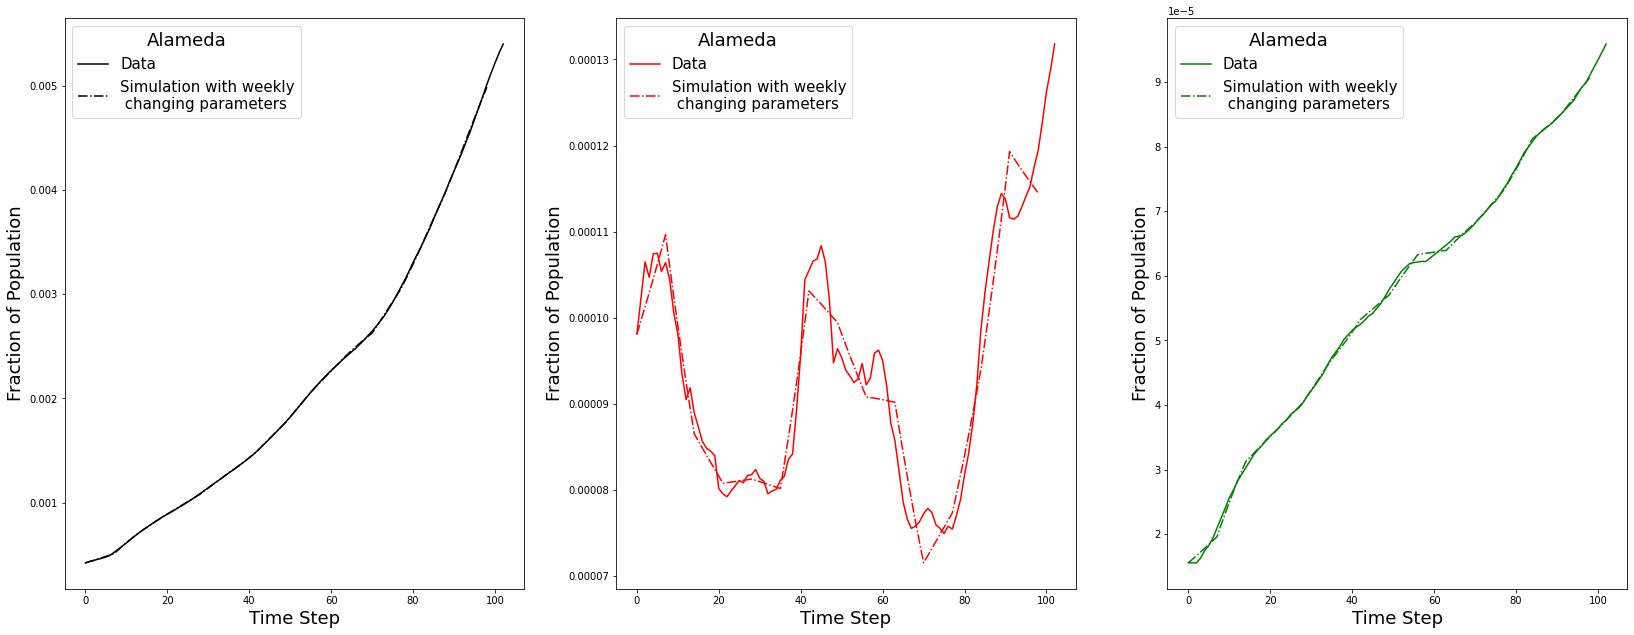

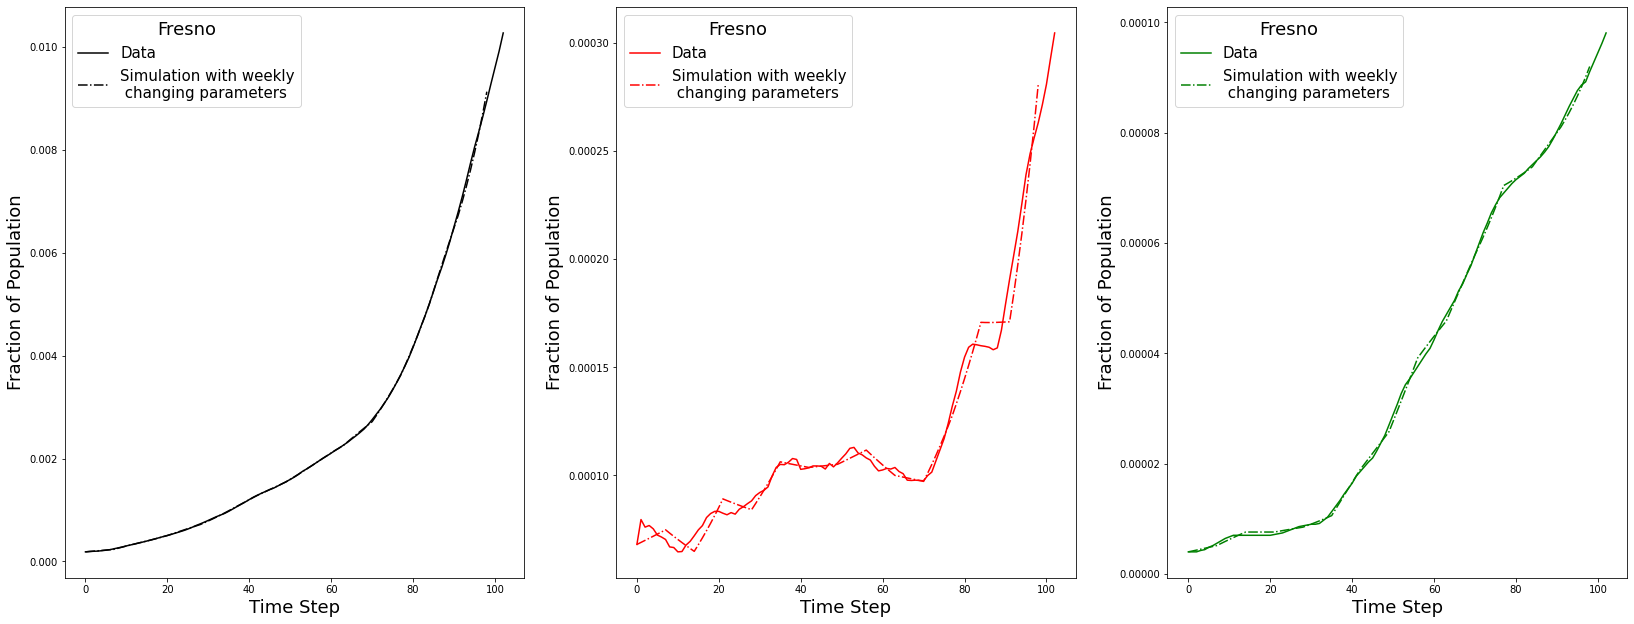

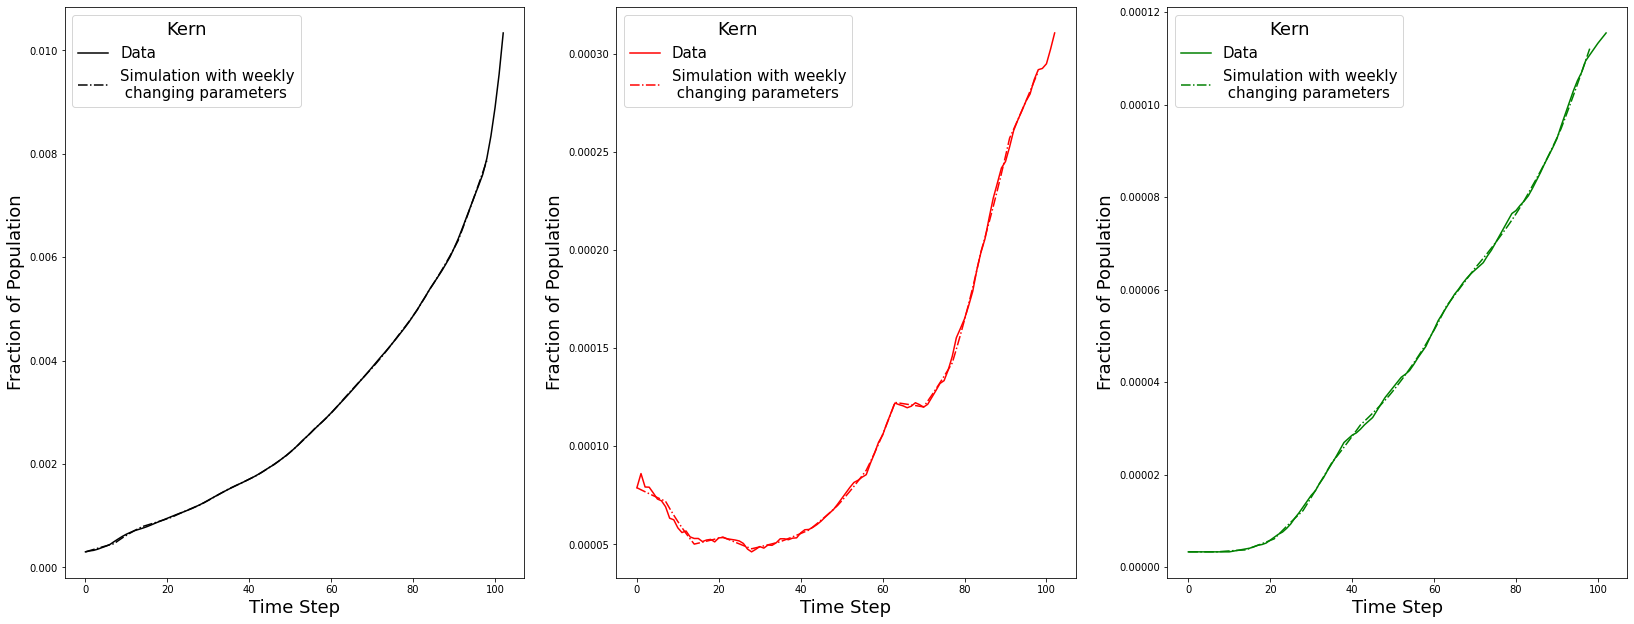

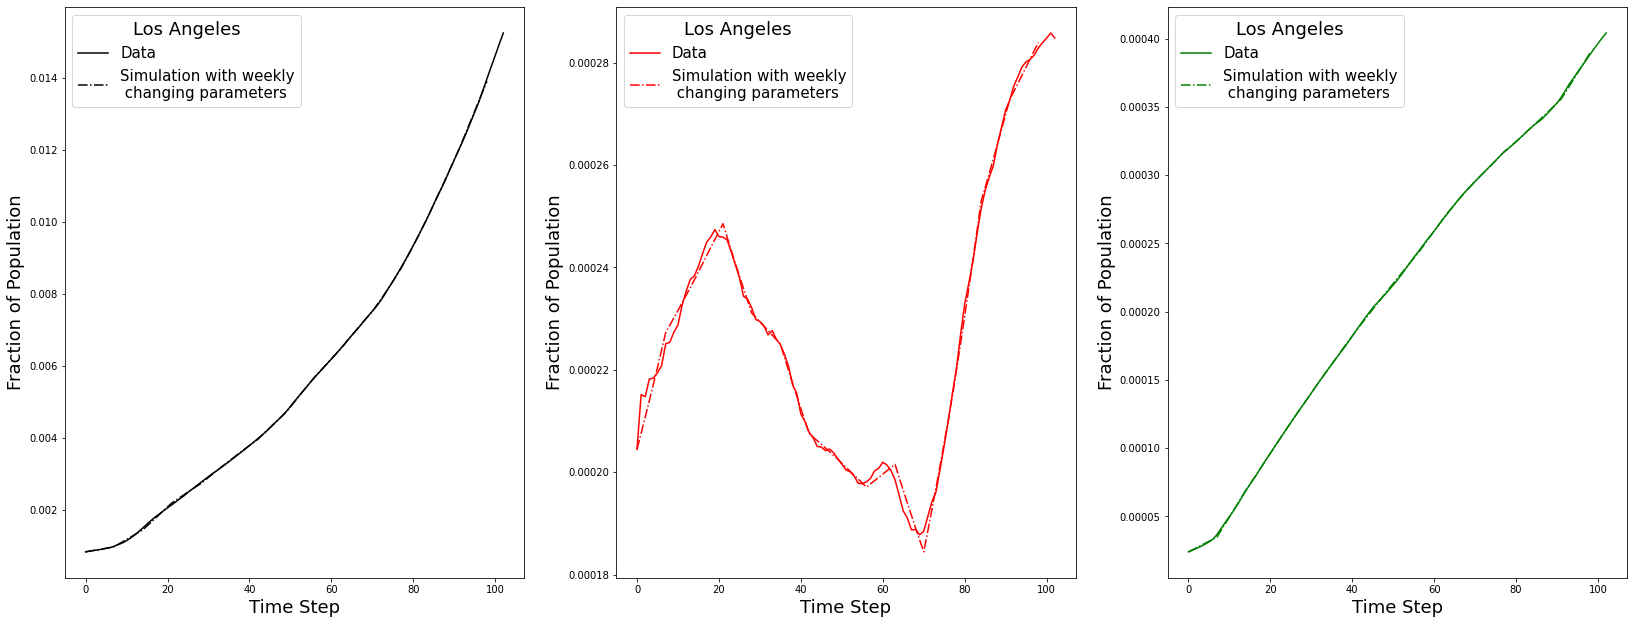

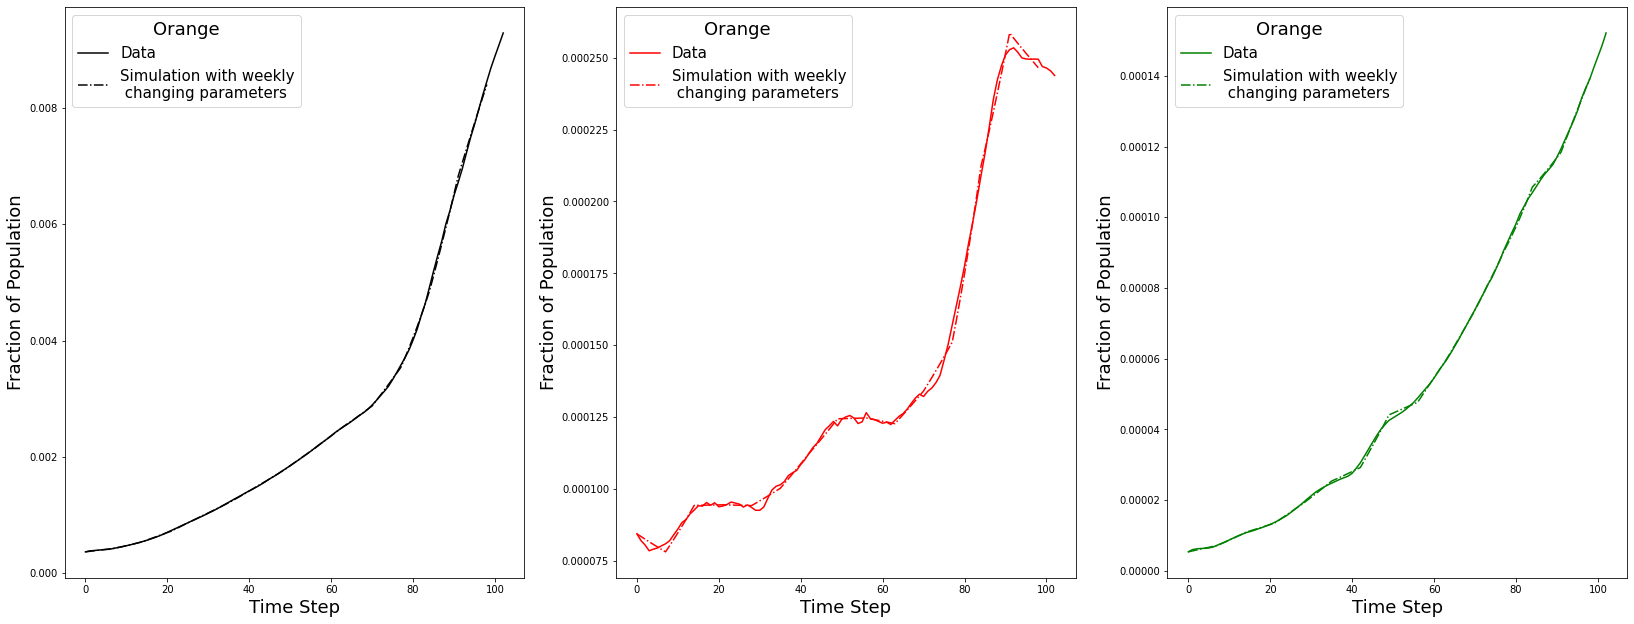

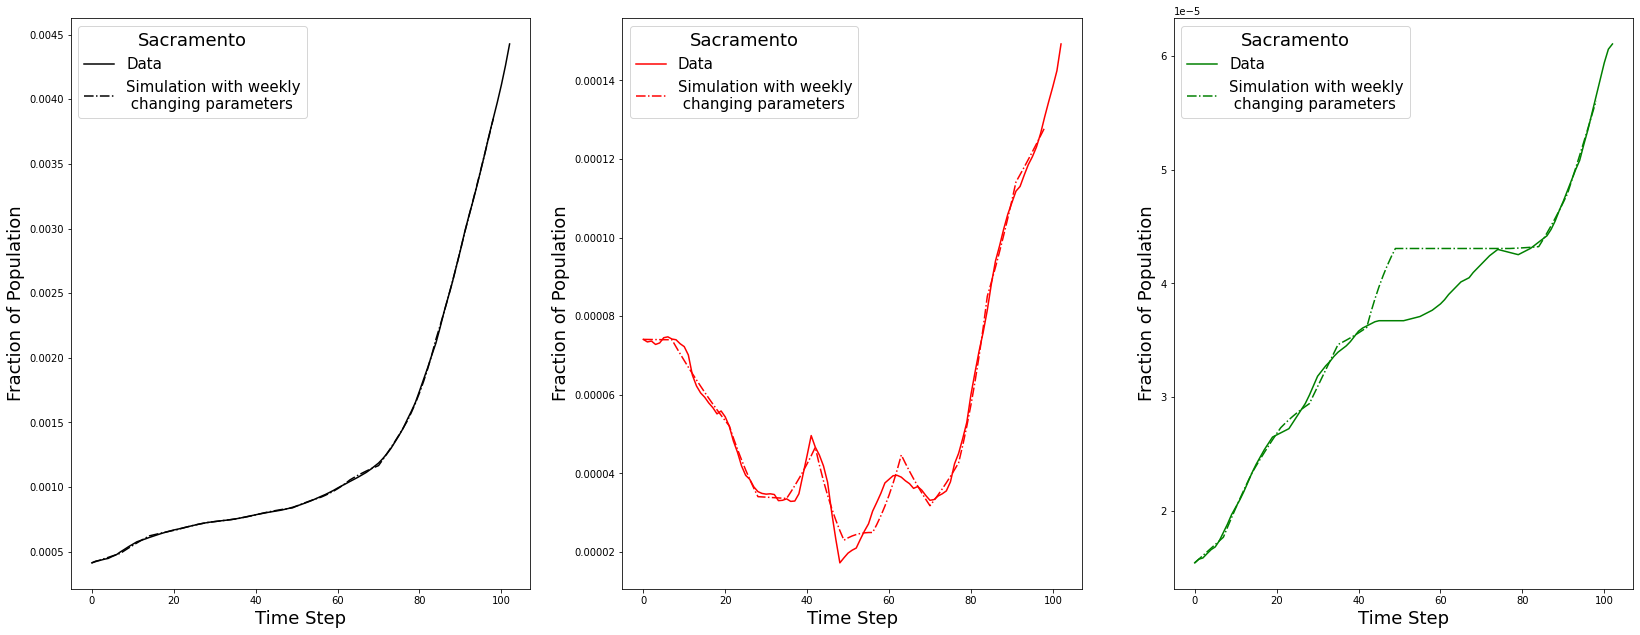

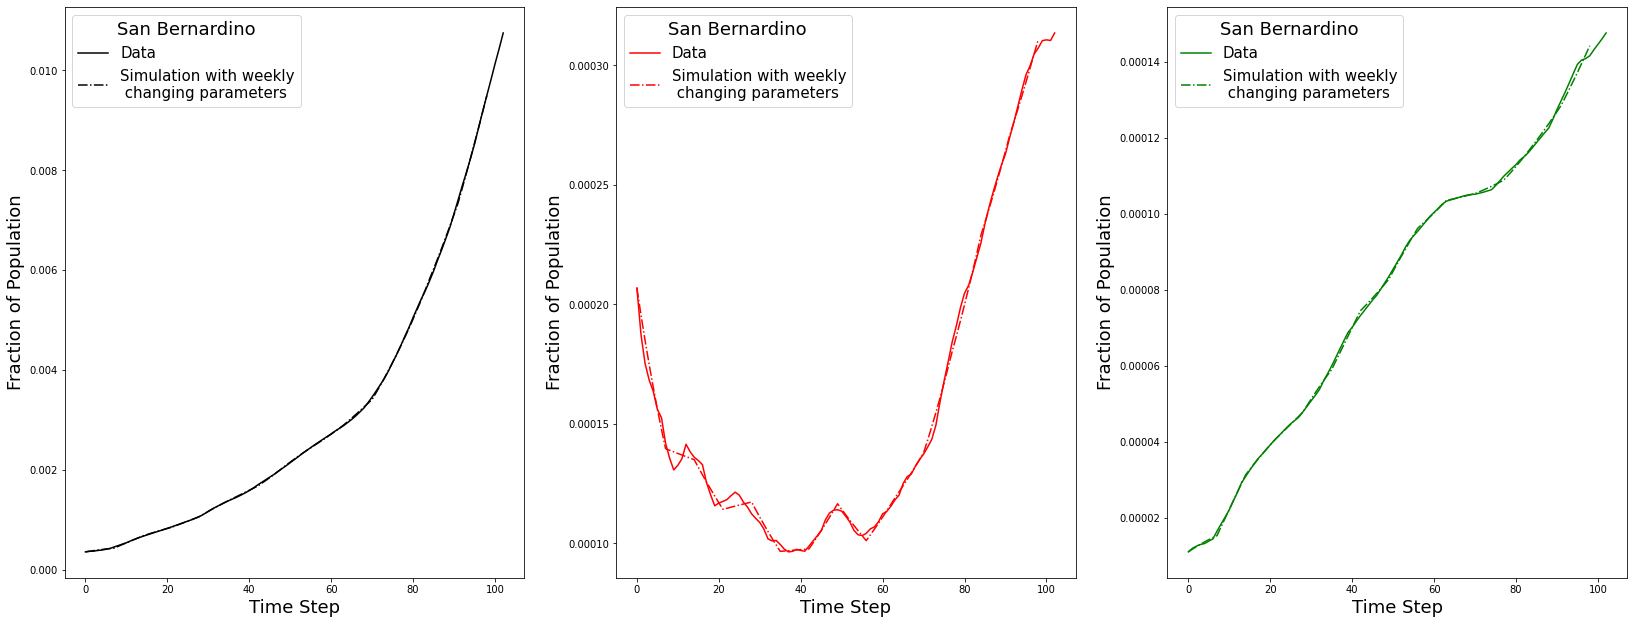

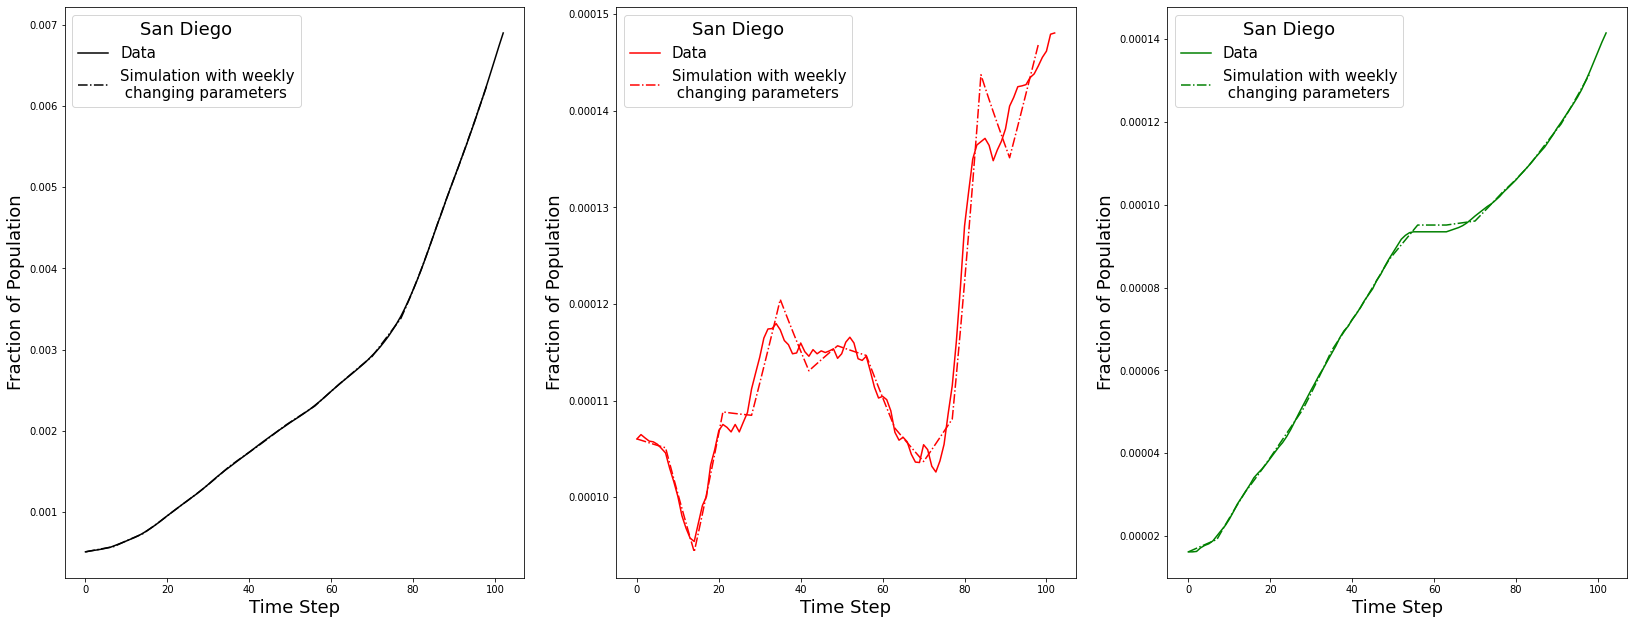

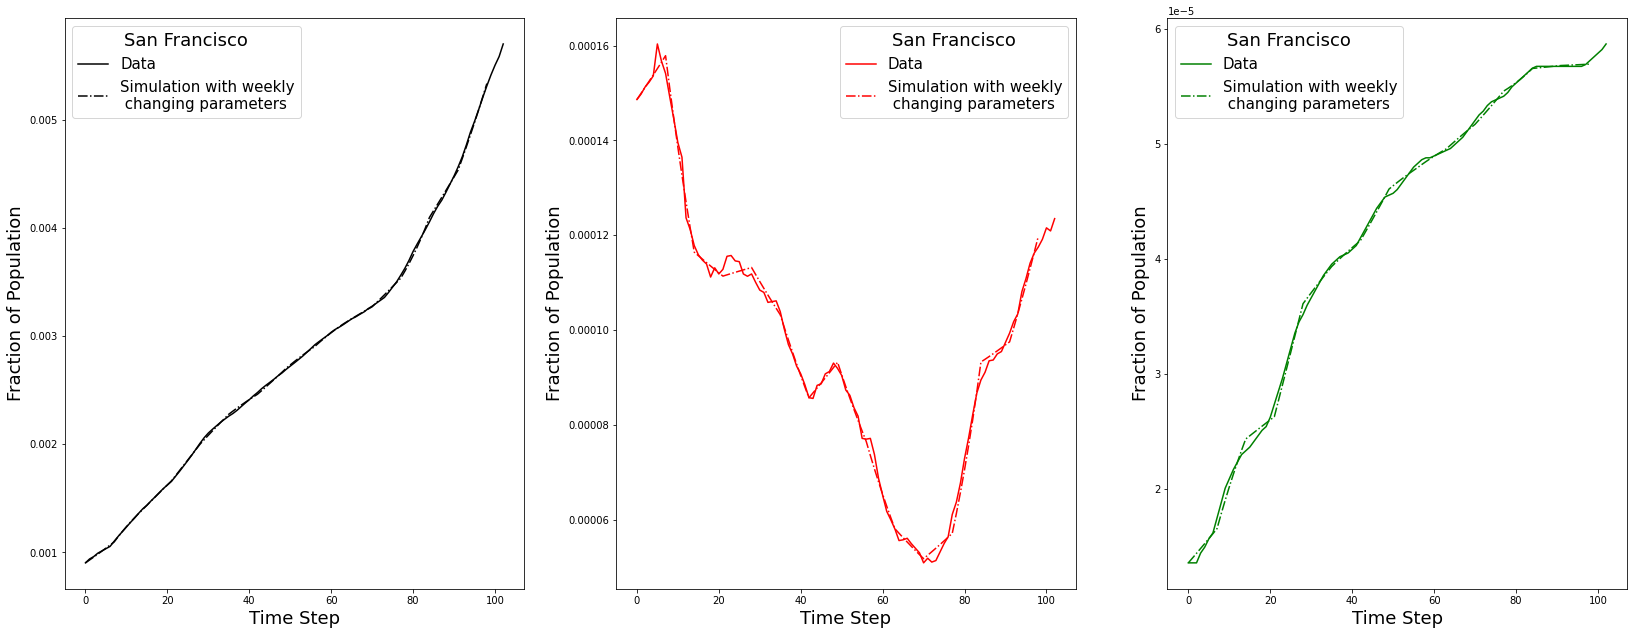

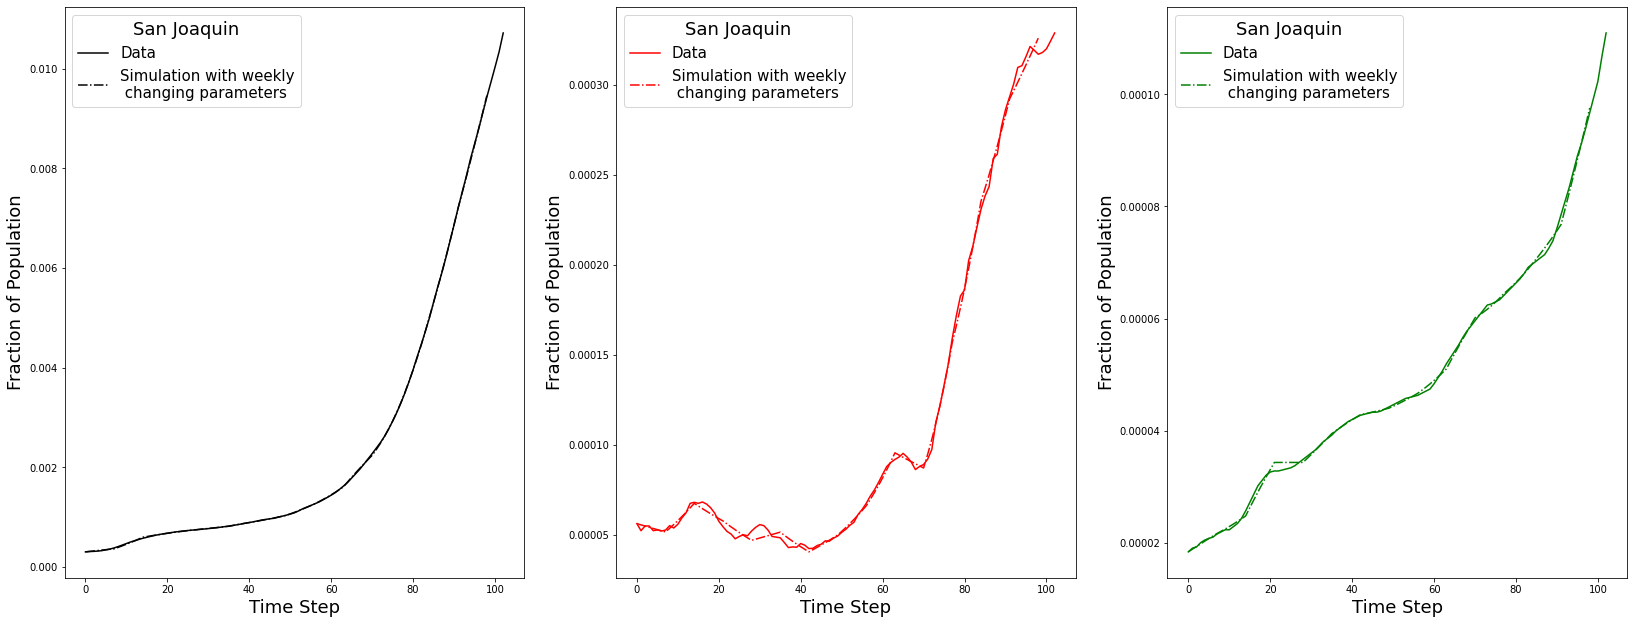

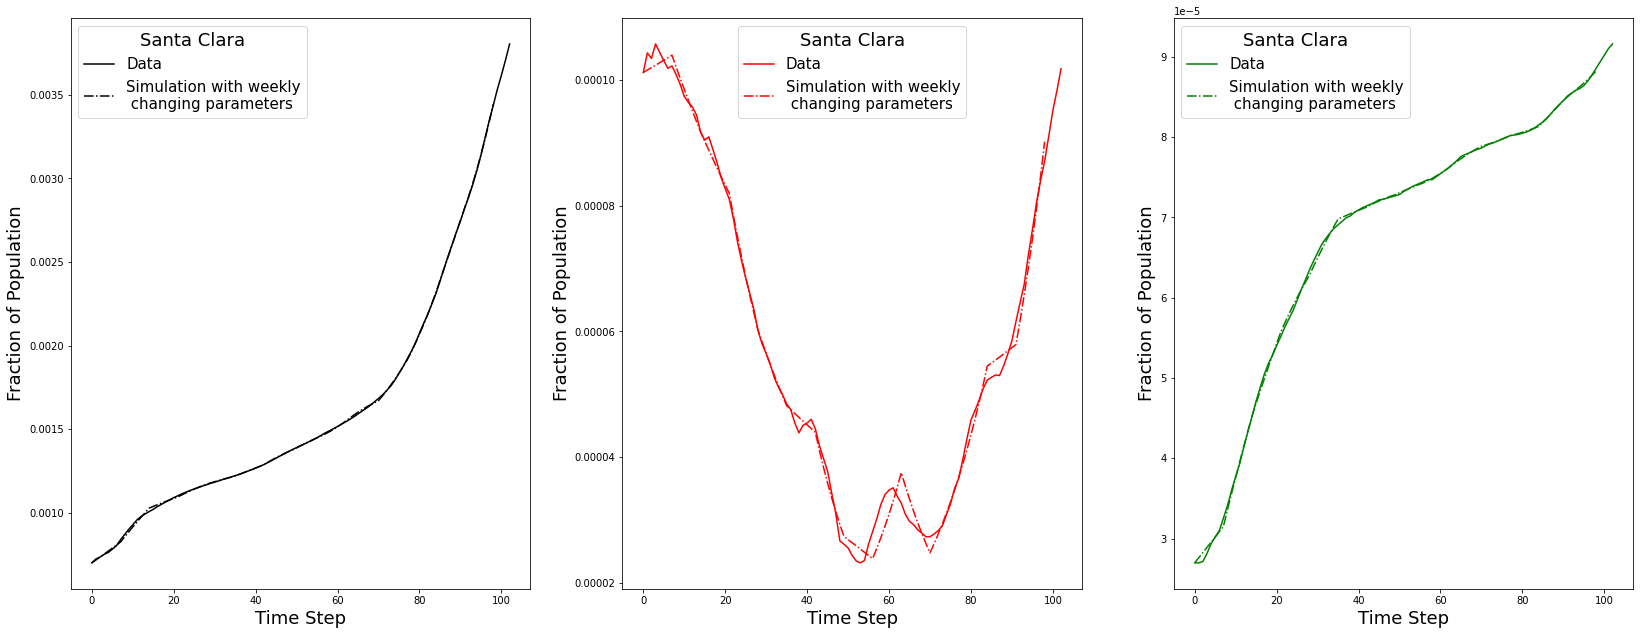

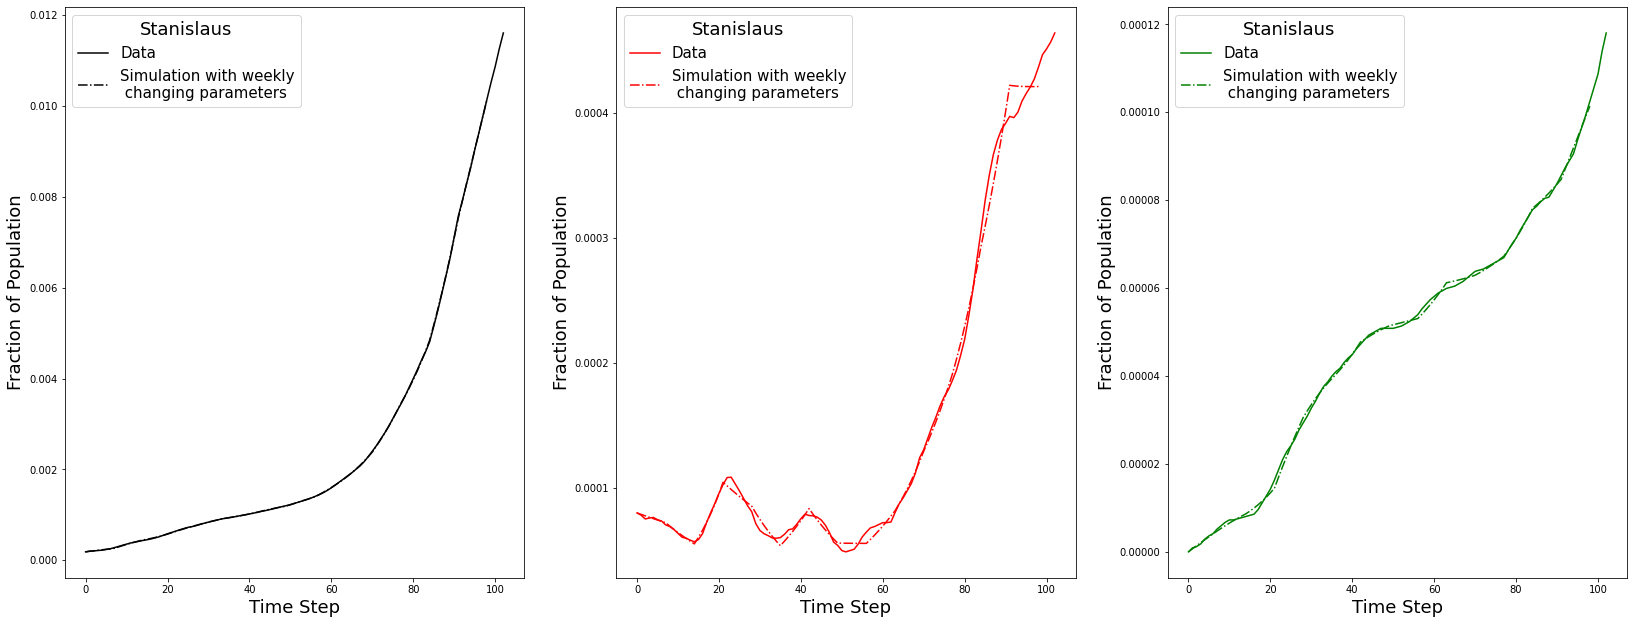

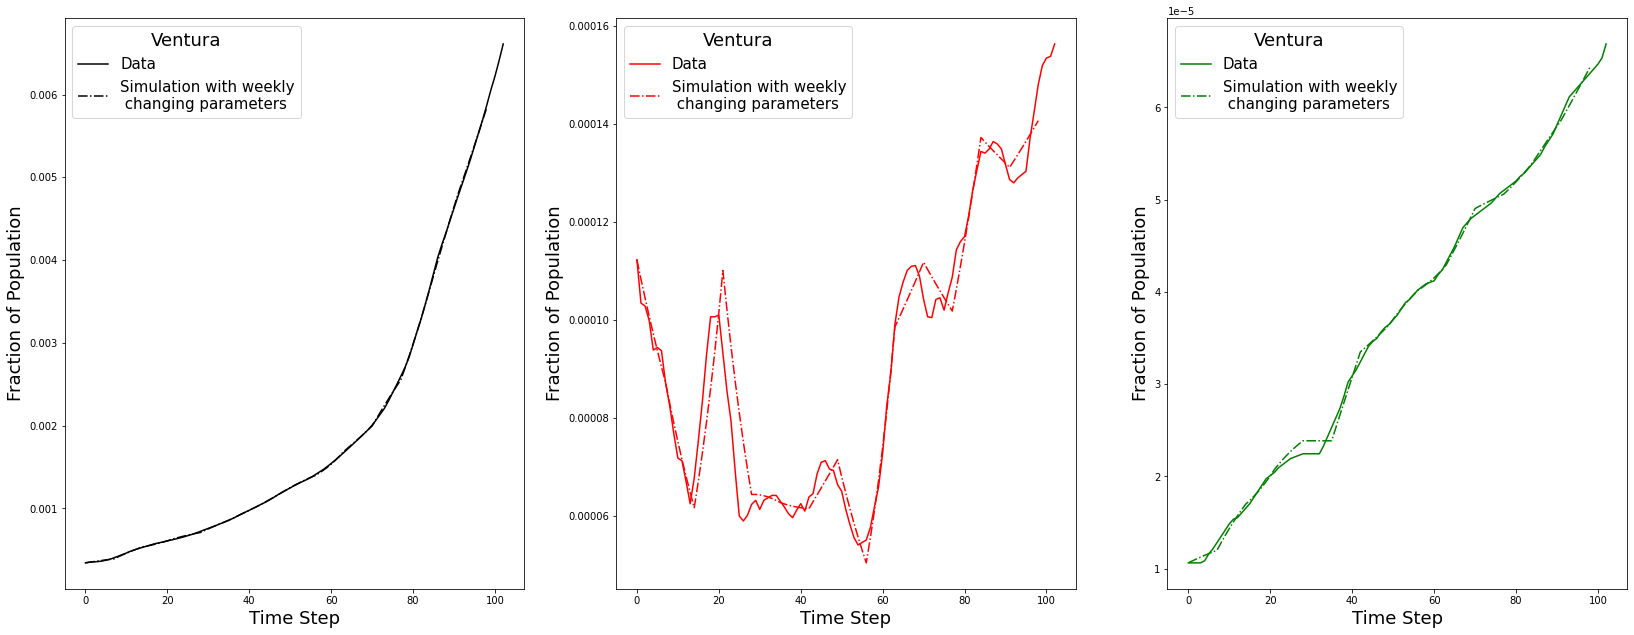

In [15]:
import matplotlib.backends.backend_pdf

def get_states(county='Los Angeles',freq=1/7,sens=0.8,spec=0.8,wind=1,thresh=0.0001,p=2.5,window=7,PD=None):
    SD = {'S':[],'Qu':[],'I':[],'D':[],'H':[],'R':[],'QR':[],'E':[],'tot':[],'total':[]}
    if PD is None:
        PD = get_PD(county=county,window=window)
    for i in range(len(PD['S'])-1):
        prev_step = []
        if i == 0:
            S0   = PD['S'][0]
            Qu0  = PD['Qu'][0]
            I0   = PD['I'][0]
            D0   = PD['D'][0]
            H0   = PD['H'][0]
            R0   = PD['R'][0]
            QR0  = PD['QR'][0]
            E0   = PD['E'][0]
            tot0 = PD['tot'][0]
            total0 = PD['total'][0]
            prev_step = [S0, Qu0, I0, D0, H0, R0, QR0, E0, tot0, total0]
            
            SD['S'].append(S0)
            SD['Qu'].append(Qu0)
            SD['I'].append(I0)
            SD['D'].append(D0)
            SD['H'].append(H0)
            SD['R'].append(R0)
            SD['QR'].append(QR0)
            SD['E'].append(E0)
            SD['tot'].append(tot0)
            SD['total'].append(total0)
            
        if i > 0: 
            prev_step = [SD['S'][-1],SD['Qu'][-1],SD['I'][-1],SD['D'][-1],SD['H'][-1],SD['R'][-1],SD['QR'][-1],SD['E'][-1],SD['tot'][-1],SD['total'][-1]]
        params = lmfit.Parameters()
        params.add('alpha' ,   np.mean(PD['alpha'][i-wind+1:i+1]) if i >= wind else np.mean(PD['alpha'][:i+1] ) , vary=False)
        params.add('eps'   ,   0               , vary=False)
        params.add('nu'    ,   np.mean(PD['nu'][i-wind+1:i+1])    if i >= wind else np.mean(PD['nu'][:i+1]    ) , vary=False)
        params.add('mu'    ,   np.mean(PD['mu'][i-wind+1:i+1])    if i >= wind else np.mean(PD['mu'][:i+1]    ) , vary=False)
        params.add('tau'   ,   np.mean(PD['tau'][i-wind+1:i+1])   if i >= wind else np.mean(PD['tau'][:i+1]   ) , vary=False)
        params.add('freq'  ,   freq            , vary=False)
        params.add('sens'  ,   sens            , vary=False)
        params.add('spec'  ,   spec            , vary=False)

        # evaluate model
        S,Qu,I,D,H,R,QR,E,tot,total = funct(prev_step,params,thresh=thresh,p=p)

        SD['S'].append(S)
        SD['Qu'].append(Qu)
        SD['I'].append(I)
        SD['D'].append(D)
        SD['H'].append(H)
        SD['R'].append(R)
        SD['QR'].append(QR)
        SD['E'].append(E)
        SD['tot'].append(tot)
        SD['total'].append(total)
        
    return SD

for county in county_fits.keys():
    # Save the plots of this 
    PD = county_fits[county]
    SD = get_states(county=county,freq=0,sens=0,spec=0,PD=PD)
    fig, (ax5,ax6,ax7) = plt.subplots(1, 3)
    fig.set_size_inches(28.0, 10.5)
    x = np.linspace(0,len(PD['tot']), len(PD['tot']))
    ax5.plot(cases_tot[county],color='black',label="Data")
    ax5.plot(PD['tot'],linestyle='dashdot',color='black',label="Simulation with weekly\n changing parameters")
    ax5.set_xlabel("Time Step",fontsize=18)
    ax5.set_ylabel("Fraction of Population",fontsize=18)
    ax5.legend(title=county,fontsize=15,title_fontsize=18)
    ax6.plot(hosp_total[county],color='red',label="Data")
    ax6.plot(PD['H'],linestyle='dashdot',color='red',label="Simulation with weekly\n changing parameters")
    ax6.set_xlabel("Time Step",fontsize=18)
    ax6.set_ylabel("Fraction of Population",fontsize=18)
    ax6.legend(title=county,fontsize=15,title_fontsize=18)
    ax7.plot(deaths_tot[county],color='green',label="Data")
    ax7.plot(PD['E'],linestyle='dashdot',color='green',label="Simulation with weekly\n changing parameters")
    ax7.set_xlabel("Time Step",fontsize=18)
    ax7.set_ylabel("Fraction of Population",fontsize=18)
    ax7.legend(title=county,fontsize=15,title_fontsize=18)
    plt.savefig(county) 

#     fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#     fig.set_size_inches(28.0, 10.5)
#     x = np.linspace(0,len(PD['mu']), len(PD['mu']))
#     ax1.plot(x,PD['alpha'],label="Time Varying alpha")
#     ax1.set_xlabel(r"$\alpha$")
#     ax1.set_ylabel("Value")
#     ax1.legend(title=county)
#     ax2.plot(x,PD['nu'],label="Time Varying nu")
#     ax2.set_xlabel(r"$\nu$")
#     ax2.set_ylabel("Value")
#     ax2.legend(title=county)
#     ax3.plot(x,PD['mu'],label="Time Varying mu")
#     ax3.set_xlabel(r"$\mu$")
#     ax3.set_ylabel("Value")
#     ax3.legend(title=county)
#     ax4.plot(x,PD['tau'],label="Time Varying tau")
#     ax4.set_xlabel(r"$\tau$")
#     ax4.set_ylabel("Value")
#     ax4.legend(title=county)
#     plt.savefig(fig,bbox_inches="tight") 
#     plt.show()
#     print(np.mean(PD['nu']))
#     plt.close(fig)

#     fig, (ax8,ax9,ax10) = plt.subplots(1, 3)
#     fig.set_size_inches(28.0, 10.5)
#     x = np.linspace(0,len(PD['I']), len(PD['I']))
# #     z = np.linspace(0,len(cases_tot), len(cases_tot))
# #     ax8.plot(x,PD['I'],linestyle='dashdot',color='black', label="Simulation state I with parameters changing daily")
#     ax8.plot(PD['D'],linestyle='dashdot',color='red'  , label="Simulation state D with parameters changing daily")
# #     ax8.plot(x,PD['R'],linestyle='dashdot',color='green', label="Simulation state R with parameters changing daily")
# #     ax8.plot(x,PD['QR'],linestyle='dashdot',color='blue', label="Simulation state QR with parameters changing daily")
#     ax8.set_xlabel("Time Step")
#     ax8.set_ylabel("Fraction of Population")
#     ax8.legend(title=county)
#     ax9.plot(np.array(PD['I'])/np.array(PD['D']),linestyle='dashdot',color='red',label="Time Varying I/D")
#     ax9.set_xlabel("Time Step")
#     ax9.set_ylabel(r"\Phi")
#     ax9.legend(title=county)
#     ax10.plot(PD['S'],linestyle='dashdot',color='black', label="Simulation state S with parameters changing daily")
#     ax10.plot(PD['Qu'],linestyle='dashdot',color='blue', label="Simulation state Qu with parameters changing daily")
#     ax10.set_xlabel("Time Step")
#     ax10.set_ylabel("Fraction of Population")
#     ax10.legend(title=county)
#     plt.show()
# #     pdf.savefig(fig,bbox_inches="tight")  
#     plt.close(fig)

In [27]:
# test sensitivity
sens = 0.8
# test specificity
spec = 0.9
# convert all decimals to percents
toPerc = 100
# testing frequencies
# pcr_freqs = np.linspace(0.0001,.03,30)

freqs = np.logspace(-17,-6.5,30,base=2) # used set set threshold
enable_protocol = -1 # -1 turns on
p = 1 # sets range for frequency in testing protocol. See funct(...) in fitting area.
# zero array the length of the simulation 
nil = np.zeros(len(cases_tot['Alameda']))
# Total county population
print(pops)
POP = np.sum([pops[county] for county in pops.keys()])
# Total cases, hospitalized, dead from data
print("Computing total cases, hospitalizations, and cases from data...")
CASES, HOSP, DEATHS = nil, nil, nil
for county in cases_tot.keys():
    CASES  = CASES  + np.array(cases_tot[county])*pops[county]
    HOSP   = HOSP   + np.array(hosp_total[county])*pops[county]
    DEATHS = DEATHS + np.array(deaths_tot[county])*pops[county]
CASES   =  CASES / POP * toPerc
HOSP    =  HOSP / POP * toPerc
DEATHS  =  DEATHS / POP * toPerc
print("Done!")


# Sum of county time series
scan = {}
county_series = {}

print("Running County Series with Testing Protocol for Map Diagram...")
# Individual county series 
map_freqs = [5.00000000e-04, 3.53553391e-04, 2.50000000e-04, 1.76776695e-04,
 1.25000000e-04, 8.83883476e-05, 6.25000000e-05, 4.41941738e-05,
 3.12500000e-05, 2.20970869e-05, 1.56250000e-05, 1.10485435e-05,
 7.81250000e-06]
map_series = {}
for freq in map_freqs:
    print("Frequency: {}/{}".format(list(map_freqs).index(freq),len(map_freqs)))
    if freq not in map_series.keys():
        map_series[freq] = {}
    for county in county_fits.keys():
        PD = county_fits[county]
        SD = get_states(county=county,freq=enable_protocol,sens=sens,spec=spec,thresh=freq,p=p,PD=PD)
        map_series[freq][county] = SD
print("Done!")

nil = np.zeros(len(county_fits['Alameda']['S']))

print("Running County Series with Testing Protocol...")
for freq in freqs:
    print("Frequency: {}/{}".format(list(freqs).index(freq),len(freqs)))
    # Compute the total California states by summing and normalizing over counties
    if freq not in scan.keys():
        scan[freq] = {'S':nil,'Qu':nil,'I':nil,'D':nil,'I+D':nil,'H':nil,'R':nil,'QR':nil,'E':nil,'tot':nil,'total':nil,'cost':nil}
        county_series[freq] = {}
    # Sum up all of the county state values
    for county in county_fits.keys():
        PD = county_fits[county]
        SD = get_states(county=county,freq=enable_protocol,sens=sens,spec=spec,thresh=freq,p=p,PD=PD)
        scan[freq]['S']     =  scan[freq]['S']     + np.array(SD['S'])  * pops[county]    
        scan[freq]['Qu']    =  scan[freq]['Qu']    + np.array(SD['Qu']) * pops[county]    
        scan[freq]['I']     =  scan[freq]['I']     + np.array(SD['I'])  * pops[county]    
        scan[freq]['D']     =  scan[freq]['D']     + np.array(SD['D'])  * pops[county]    
        scan[freq]['I+D']   =  scan[freq]['I+D']   + (np.array(SD['D']) + np.array(SD['I'])) * pops[county] 
        scan[freq]['H']     =  scan[freq]['H']     + np.array(SD['H'])  * pops[county]    
        scan[freq]['R']     =  scan[freq]['R']     + np.array(SD['R'])  * pops[county]
        scan[freq]['QR']    =  scan[freq]['QR']    + np.array(SD['QR']) * pops[county]    
        scan[freq]['E']     =  scan[freq]['E']     + np.array(SD['E'])  * pops[county]    
        scan[freq]['tot']   =  scan[freq]['tot']   + np.array(SD['tot']) * pops[county]   
        scan[freq]['total'] =  scan[freq]['total'] + np.array(SD['total']) * pops[county] 
        county_series[freq][county] = SD
    # Convert to fraction of total CA population
    for key in scan[freq].keys():
        scan[freq][key] /= POP
    print(scan[freq]['total'][-1],freq)
        
    # Make sure total population is 1.0 as safekeeping
    for i in range(len(scan[freq]['S'])):
        pop = 0
        for key in scan[freq].keys():
            pop += scan[freq][key][i]
        if round(pop) != 1.0: print(i,round(pop))
            
    # Convert to percent
    for key in scan[freq].keys():
        scan[freq][key] *= toPerc
print("Done!")

pcr_series = {}
pcr_scan = {}

print("Running County Series with PCR Nonuniform Testing Protocol...")
for freq in freqs:
    print("Frequency: {}/{}".format(list(freqs).index(freq),len(freqs)))
    # Compute the total California states by summing and normalizing over counties
    if freq not in pcr_scan.keys():
        pcr_scan[freq] = {'S':nil,'Qu':nil,'I':nil,'D':nil,'I+D':nil,'H':nil,'R':nil,'QR':nil,'E':nil,'tot':nil,'total':nil,'cost':nil}
        pcr_series[freq] = {}
    # Sum up all of the county state values
    for county in county_fits.keys():
        PD = county_fits[county]
        SD = get_states(county=county,freq=enable_protocol,sens=1.0,spec=1.0,thresh=freq,p=p,PD=PD)
        pcr_scan[freq]['S']     =  pcr_scan[freq]['S']     + np.array(SD['S'])  * pops[county]    
        pcr_scan[freq]['Qu']    =  pcr_scan[freq]['Qu']    + np.array(SD['Qu']) * pops[county]    
        pcr_scan[freq]['I']     =  pcr_scan[freq]['I']     + np.array(SD['I'])  * pops[county]    
        pcr_scan[freq]['D']     =  pcr_scan[freq]['D']     + np.array(SD['D'])  * pops[county]    
        pcr_scan[freq]['I+D']   =  pcr_scan[freq]['I+D']   + (np.array(SD['D']) + np.array(SD['I'])) * pops[county] 
        pcr_scan[freq]['H']     =  pcr_scan[freq]['H']     + np.array(SD['H'])  * pops[county]    
        pcr_scan[freq]['R']     =  pcr_scan[freq]['R']     + np.array(SD['R'])  * pops[county]
        pcr_scan[freq]['QR']    =  pcr_scan[freq]['QR']    + np.array(SD['QR']) * pops[county]    
        pcr_scan[freq]['E']     =  pcr_scan[freq]['E']     + np.array(SD['E'])  * pops[county]    
        pcr_scan[freq]['tot']   =  pcr_scan[freq]['tot']   + np.array(SD['tot']) * pops[county]   
        pcr_scan[freq]['total'] =  pcr_scan[freq]['total'] + np.array(SD['total']) * pops[county] 
        pcr_series[freq][county] = SD
    # Convert to fraction of total CA population
    for key in pcr_scan[freq].keys():
        pcr_scan[freq][key] /= POP
    print(pcr_scan[freq]['total'][-1],freq)
        
    # Make sure total population is 1.0 as safekeeping
    for i in range(len(pcr_scan[freq]['S'])):
        pop = 0
        for key in pcr_scan[freq].keys():
            pop += pcr_scan[freq][key][i]
        if round(pop) != 1.0: print(i,round(pop))
            
    # Convert to percent
    for key in pcr_scan[freq].keys():
        pcr_scan[freq][key] *= toPerc
print("Done!")

freqs_uniform = np.linspace(0.02,1,30)
pcr_series_uniform = {}
pcr_scan_uniform = {}

print("Running County Series with PCR Uniform Testing Protocol...")
for freq in freqs_uniform:
    print("Frequency: {}/{}".format(list(freqs_uniform).index(freq),len(freqs_uniform)))
    # Compute the total California states by summing and normalizing over counties
    if freq not in pcr_scan_uniform.keys():
        pcr_scan_uniform[freq] = {'S':nil,'Qu':nil,'I':nil,'D':nil,'I+D':nil,'H':nil,'R':nil,'QR':nil,'E':nil,'tot':nil,'total':nil,'cost':nil}
        pcr_series_uniform[freq] = {}
    # Sum up all of the county state values
    for county in county_fits.keys():
        PD = county_fits[county]
        SD = get_states(county=county,freq=freq,sens=1.0,spec=1.0,PD=PD)
        pcr_scan_uniform[freq]['S']     =  pcr_scan_uniform[freq]['S']     + np.array(SD['S'])  * pops[county]    
        pcr_scan_uniform[freq]['Qu']    =  pcr_scan_uniform[freq]['Qu']    + np.array(SD['Qu']) * pops[county]    
        pcr_scan_uniform[freq]['I']     =  pcr_scan_uniform[freq]['I']     + np.array(SD['I'])  * pops[county]    
        pcr_scan_uniform[freq]['D']     =  pcr_scan_uniform[freq]['D']     + np.array(SD['D'])  * pops[county]    
        pcr_scan_uniform[freq]['I+D']   =  pcr_scan_uniform[freq]['I+D']   + (np.array(SD['D']) + np.array(SD['I'])) * pops[county] 
        pcr_scan_uniform[freq]['H']     =  pcr_scan_uniform[freq]['H']     + np.array(SD['H'])  * pops[county]    
        pcr_scan_uniform[freq]['R']     =  pcr_scan_uniform[freq]['R']     + np.array(SD['R'])  * pops[county]
        pcr_scan_uniform[freq]['QR']    =  pcr_scan_uniform[freq]['QR']    + np.array(SD['QR']) * pops[county]    
        pcr_scan_uniform[freq]['E']     =  pcr_scan_uniform[freq]['E']     + np.array(SD['E'])  * pops[county]    
        pcr_scan_uniform[freq]['tot']   =  pcr_scan_uniform[freq]['tot']   + np.array(SD['tot']) * pops[county]   
        pcr_scan_uniform[freq]['total'] =  pcr_scan_uniform[freq]['total'] + np.array(SD['total']) * pops[county] 
        pcr_series_uniform[freq][county] = SD
    # Convert to fraction of total CA population
    for key in pcr_scan_uniform[freq].keys():
        pcr_scan_uniform[freq][key] /= POP
    print(pcr_scan_uniform[freq]['total'][-1],freq)
        
    # Make sure total population is 1.0 as safekeeping
    for i in range(len(pcr_scan_uniform[freq]['S'])):
        pop = 0
        for key in pcr_scan_uniform[freq].keys():
            pop += pcr_scan_uniform[freq][key][i]
        if round(pop) != 1.0: print(i,round(pop))
            
    # Convert to percent
    for key in pcr_scan_uniform[freq].keys():
        pcr_scan_uniform[freq][key] *= toPerc
print("Done!")


# testing frequencies for uniform scan
# Sum of county time series
scan_uniform = {}
# Individual county series
county_series_uniform = {}

print("Running County Series with Testing Protocol...")
for freq in freqs_uniform:
    print("Frequency: {}/{}".format(list(freqs_uniform).index(freq),len(freqs_uniform)))
    # Compute the total California states by summing and normalizing over counties
    if freq not in scan_uniform.keys():
        scan_uniform[freq] = {'S':nil,'Qu':nil,'I':nil,'D':nil,'I+D':nil,'H':nil,'R':nil,'QR':nil,'E':nil,'tot':nil,'total':nil,'cost':nil}
        county_series_uniform[freq] = {}
    # Sum up all of the county state values
    for county in county_fits.keys():
        PD = county_fits[county]
        SD = get_states(county=county,freq=freq,sens=sens,spec=spec,PD=PD)
        scan_uniform[freq]['S']     =  scan_uniform[freq]['S']     + np.array(SD['S'])  * pops[county]    
        scan_uniform[freq]['Qu']    =  scan_uniform[freq]['Qu']    + np.array(SD['Qu']) * pops[county]    
        scan_uniform[freq]['I']     =  scan_uniform[freq]['I']     + np.array(SD['I'])  * pops[county]    
        scan_uniform[freq]['D']     =  scan_uniform[freq]['D']     + np.array(SD['D'])  * pops[county]    
        scan_uniform[freq]['I+D']   =  scan_uniform[freq]['I+D']   + (np.array(SD['D']) + np.array(SD['I'])) * pops[county] 
        scan_uniform[freq]['H']     =  scan_uniform[freq]['H']     + np.array(SD['H'])  * pops[county]    
        scan_uniform[freq]['R']     =  scan_uniform[freq]['R']     + np.array(SD['R'])  * pops[county]
        scan_uniform[freq]['QR']    =  scan_uniform[freq]['QR']    + np.array(SD['QR']) * pops[county]    
        scan_uniform[freq]['E']     =  scan_uniform[freq]['E']     + np.array(SD['E'])  * pops[county]    
        scan_uniform[freq]['tot']   =  scan_uniform[freq]['tot']   + np.array(SD['tot']) * pops[county]   
        scan_uniform[freq]['total'] =  scan_uniform[freq]['total'] + np.array(SD['total']) * pops[county] 
        county_series_uniform[freq][county] = SD
    # Convert to fraction of total CA population
    for key in scan_uniform[freq].keys():
        scan_uniform[freq][key] /= POP
        
    # Make sure total population is 1.0 as safekeeping
    for i in range(len(scan_uniform[freq]['S'])):
        pop = 0
        for key in scan_uniform[freq].keys():
            pop += scan_uniform[freq][key][i]
        if round(pop) != 1.0: print(i,round(pop))
            
    # Convert to percent
    for key in scan_uniform[freq].keys():
        scan_uniform[freq][key] *= toPerc
print("Done!")

{'Alameda': 1671329, 'Fresno': 999101, 'Kern': 900202, 'Los Angeles': 10039107, 'Orange': 3175692, 'Sacramento': 1552058, 'San Bernardino': 2180085, 'San Diego': 3338330, 'San Francisco': 881549, 'San Joaquin': 762148, 'Santa Clara': 1927852, 'Stanislaus': 550660, 'Ventura': 846006}
Computing total cases, hospitalizations, and cases from data...
Done!
Running County Series with Testing Protocol for Map Diagram...
Frequency: 0/13
Frequency: 1/13
Frequency: 2/13
Frequency: 3/13
Frequency: 4/13
Frequency: 5/13
Frequency: 6/13
Frequency: 7/13
Frequency: 8/13
Frequency: 9/13
Frequency: 10/13
Frequency: 11/13
Frequency: 12/13
Done!
Running County Series with Testing Protocol...
Frequency: 0/30
0.008843289534678778 7.62939453125e-06
Frequency: 1/30
0.008843290825238043 9.80581494127364e-06
Frequency: 2/30
0.008843293266530786 1.26030979612679e-05
Frequency: 3/30
0.008843297759804242 1.619835568716985e-05
Frequency: 4/30
0.008843305632973678 2.081922458862419e-05
Frequency: 5/30
0.008843318231

KeyboardInterrupt: 

In [34]:
sdate = '04/10/2020'
sdate = datetime.strptime(sdate,"%m/%d/%Y").date()
model_dates = [sdate]
tick_dates = []
for i in range(1,len(scan[freqs[-1]]['S'])):
    day = sdate + timedelta(days=i)
    model_dates.append(day)
    if(day.day == 1):
        tick_dates.append(day)
        
def make_fig_dates():
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(111)
    formatter = mdates.DateFormatter("%Y-%m-%d")
    locator = mdates.MonthLocator()
    locator_days = mdates.DayLocator()
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
    ax.set_xlabel("Date",fontsize=20)
    ax.xaxis.set_ticks(tick_dates)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylabel("Percent of Population (%)",fontsize=20)
    ax.tick_params(labelsize=15, direction='out', length=6, width=2)
    #ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
    ax.yaxis.offsetText.set_fontsize(20)
    ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])
    
    return f,ax

def make_fig(f=None,ax=None):
    if f == None and ax == None:
        f = plt.figure(figsize=(10,10))
        ax = f.add_subplot(111)
    ax.set_xlabel("Frequency",fontsize=18)
    ax.set_ylabel("Percent of Population",fontsize=18)
    def func(x,pos):
        if str(np.around(x,2)) ==str(x):
            return x
        return np.format_float_scientific(x,precision=2)
    ax.tick_params(labelsize=16, direction='out', length=6, width=2)
    # ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
    ax.yaxis.offsetText.set_fontsize(14)
    ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])
    return f,ax

[1.6562227611621194, 1.7488460332919438, 1.8394712200086385, 1.9367458886922326, 2.0266778987216614, 2.1232996507109765, 2.21233576204484, 2.308513937296094, 2.400025293137766, 2.4991035197198292, 2.592896400401742, 2.718159631831854, 2.8606361425196796]
30


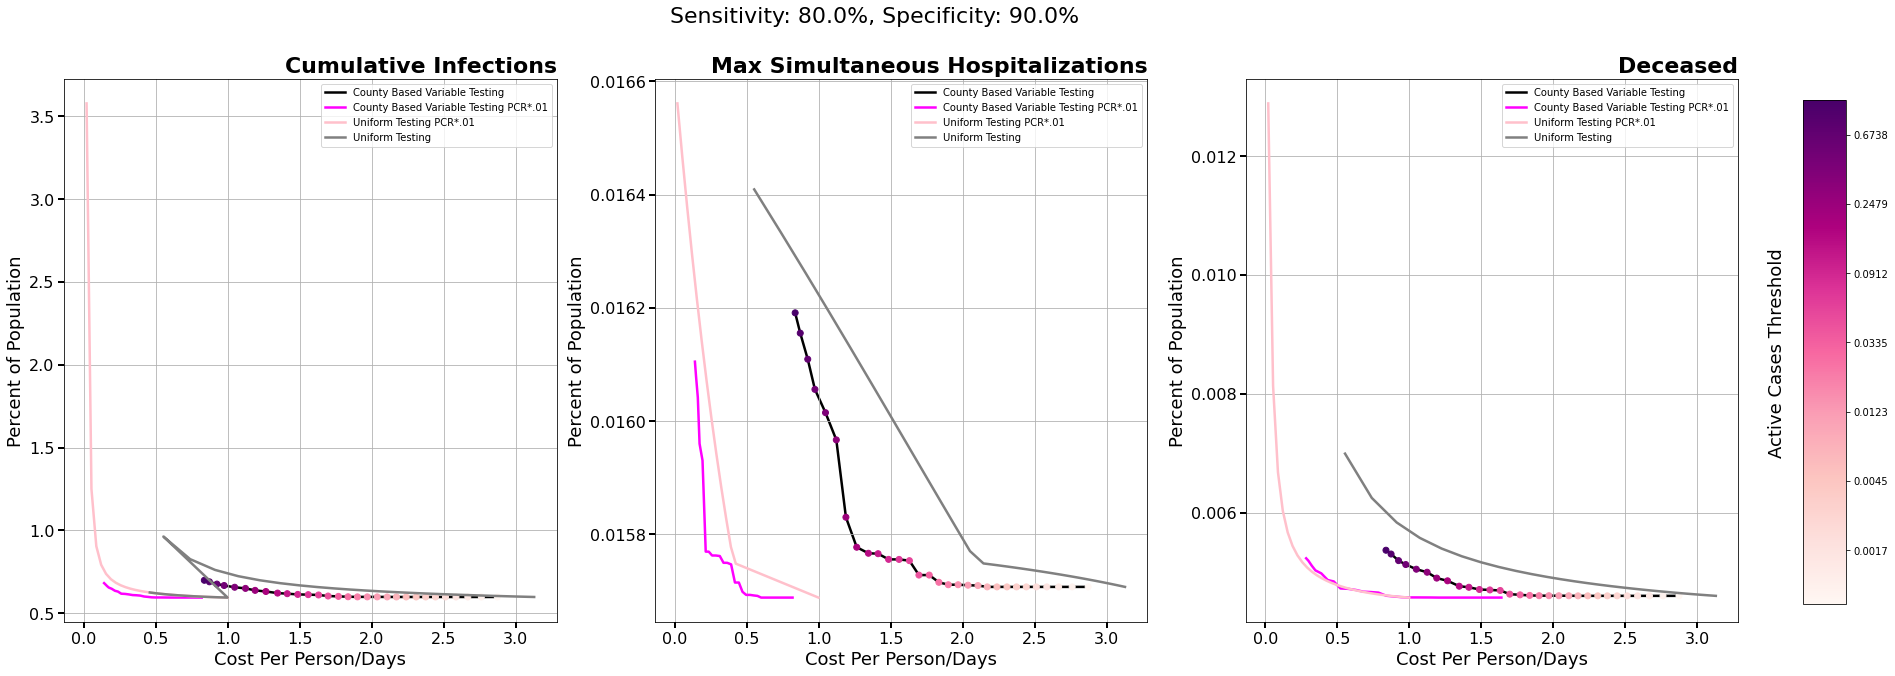

In [35]:
from matplotlib.ticker import FuncFormatter


cp = []
price = 7
tp = []
p = 1

for freq in map_series:
#     length = len(sts['total'])
#     tp.append(sts['total'][-1])
    cost = 0
    for county in map_series[freq]:
        thresh = freq
        length = len(map_series[freq][county]['S'])
        for i in range(len(map_series[freq][county]['S'])):
            D = map_series[freq][county]['D'][i]
            if D <= thresh and D >= 0.000001:
                f = 1/np.round(p*np.log2(thresh/D)+1,0)
            elif D < 0.000001:
                f = 0
            else:
                f = 1.0
            cost += f*price*(map_series[freq][county]['S'][i]+map_series[freq][county]['I'][i]+map_series[freq][county]['R'][i])*(pops[county][0])
    cp.append(cost/(length*POP))

print(cp)


fig = plt.figure(figsize=(30,10))
ax0 = fig.add_subplot(131)
plt.suptitle('Sensitivity: {}%, Specificity: {}%'.format(str(np.around(100*sens,1)),np.around(100*spec,1)),fontsize=22)
fig,ax0 = make_fig(fig,ax0)
cp = []
price = 7
tp = []


for freq, sts in scan.items():
    length = len(sts['total'])
    tp.append(sts['total'][-1])
    cost = 0
    for county in county_series[freq]:
        thresh = freq
        for i in range(len(county_series[freq][county]['S'])):
            D = county_series[freq][county]['D'][i]
            if D <= thresh and D >= 0.000001:
                f = 1/np.round(p*np.log2(thresh/D)+1,0)
            elif D < 0.000001:
                f = 0
            else:
                f = 1.0
            cost += f*price*(county_series[freq][county]['S'][i]+county_series[freq][county]['I'][i]+county_series[freq][county]['R'][i])*(pops[county][0])
    cp.append(cost/(length*POP))

ax0.plot(cp,tp,color='black',linewidth=2.5,zorder=1,label='County Based Variable Testing')
ax0.set_xlabel('Cost Per Person/Days')
print(len([np.log(f) for f in freqs]))
sc = ax0.scatter(cp,tp,marker='o',c = [np.log(f) for f in freqs],cmap = 'RdPu',zorder=2)

cp = []
price = 7
tp = []

for freq, sts in pcr_scan.items():
    tp.append(sts['total'][-1])
    cost = 0
    for county in pcr_series[freq]:
        thresh = freq
        for i in range(len(pcr_series[freq][county]['S'])):
            D = pcr_series[freq][county]['D'][i]
            if D <= thresh and D >= 0.000001:
                f = 1/np.round(p*np.log2(thresh/D)+1,0)
            elif D < 0.000001:
                f = 0
            else:
                f = 1.0
            cost += f*100*(pcr_series[freq][county]['S'][i]+pcr_series[freq][county]['I'][i]+pcr_series[freq][county]['R'][i])*(pops[county][0])
    cp.append(cost/(100*length*POP))

ax0.plot(cp,tp,color='magenta',linewidth=2.5,label='County Based Variable Testing PCR*.01')


cp = []
price = 7
tp = []

for freq, sts in pcr_scan_uniform.items():
    tp.append(sts['total'][-1])
    cost = 0
    for county in pcr_series_uniform[freq]:
        thresh = freq
        for i in range(len(pcr_series_uniform[freq][county]['S'])):
            D = pcr_series_uniform[freq][county]['D'][i]
            f = freq
            cost += f*100*(pcr_series_uniform[freq][county]['S'][i]+pcr_series_uniform[freq][county]['I'][i]+pcr_series_uniform[freq][county]['R'][i])*(pops[county][0])
    cp.append(cost/(100*length*POP))

ax0.plot(cp,tp,color='pink',linewidth=2.5,label='Uniform Testing PCR*.01')


for freq, sts in scan_uniform.items():
    tp.append(sts['total'][-1])
    cost = 0
    for county in county_series_uniform[freq]:
        thresh = freq
        for i in range(len(county_series_uniform[freq][county]['S'])):
            D = county_series_uniform[freq][county]['D'][i]
            f= freq
            cost += f*price*(county_series_uniform[freq][county]['S'][i]+county_series_uniform[freq][county]['I'][i]+county_series_uniform[freq][county]['R'][i])*(pops[county][0])
    cp.append(cost/(length*POP))

ax0.plot([c for c in cp if c > 50/length ],[tp[t] for t in range(len(tp)) if cp[t] > 50/length ],color='grey',linewidth=2.5,label='Uniform Testing')
ax0.set_title('Cumulative Infections',fontsize = 22,fontweight='bold',x=1.0,horizontalalignment='right')
ax0.legend()
plt.grid()

ax0 = fig.add_subplot(132)
fig,ax0 = make_fig(fig,ax0)
cp = []
price = 7
tp = []

for freq, sts in scan.items():
    tp.append(np.max(sts['H']))
    cost = 0
    for county in county_series[freq]:
        thresh = freq
        for i in range(len(county_series[freq][county]['S'])):
            D = county_series[freq][county]['D'][i]
            if D <= thresh and D >= 0.000001:
                f = 1/np.round(p*np.log2(thresh/D)+1,0)
            elif D < 0.000001:
                f = 0
            else:
                f = 1.0
            cost += f*price*(county_series[freq][county]['S'][i]+county_series[freq][county]['I'][i]+county_series[freq][county]['R'][i])*(pops[county][0])
    cp.append(cost/(POP*len(sts['H'])))

ax0.plot(cp,tp,color='black',linewidth=2.5,zorder=1,label='County Based Variable Testing')
ax0.set_xlabel('Cost Per Person/Days')
sc = ax0.scatter(cp,tp,marker='o',c = [np.log(f) for f in freqs],cmap = 'RdPu',zorder=2)

cp = []
price = 7
tp = []

for freq, sts in pcr_scan.items():
    tp.append(np.max(sts['H']))
    cost = 0
    for county in pcr_series[freq]:
        thresh = freq
        for i in range(len(pcr_series[freq][county]['S'])):
            D = pcr_series[freq][county]['D'][i]
            if D <= thresh and D >= 0.000001:
                f = 1/np.round(p*np.log2(thresh/D)+1,0)
            elif D < 0.000001:
                f = 0
            else:
                f = 1.0
            cost += f*100*(pcr_series[freq][county]['S'][i]+pcr_series[freq][county]['I'][i]+pcr_series[freq][county]['R'][i])*(pops[county][0])
    cp.append(cost/(100*length*POP))

ax0.plot(cp,tp,color='magenta',linewidth=2.5,label='County Based Variable Testing PCR*.01')


cp = []
price = 7
tp = []

for freq, sts in pcr_scan_uniform.items():
    tp.append(np.max(sts['H']))
    cost = 0
    for county in pcr_series_uniform[freq]:
        thresh = freq
        for i in range(len(pcr_series_uniform[freq][county]['S'])):
            D = pcr_series_uniform[freq][county]['D'][i]
            f = freq
            cost += f*100*(pcr_series_uniform[freq][county]['S'][i]+pcr_series_uniform[freq][county]['I'][i]+pcr_series_uniform[freq][county]['R'][i])*(pops[county][0])
    cp.append(cost/(100*length*POP))

ax0.plot(cp,tp,color='pink',linewidth=2.5,label='Uniform Testing PCR*.01')

cp = []
price = 7
tp = []

for freq, sts in scan_uniform.items():
    tp.append(np.max(sts['H']))
    cost = 0
    for county in county_series_uniform[freq]:
        thresh = freq
        for i in range(len(county_series_uniform[freq][county]['S'])):
            D = county_series_uniform[freq][county]['D'][i]
            f= freq
            cost += f*price*(county_series_uniform[freq][county]['S'][i]+county_series_uniform[freq][county]['I'][i]+county_series_uniform[freq][county]['R'][i])*(pops[county][0])
    cp.append(cost/(len(sts['H'])*POP))
ax0.plot([c for c in cp if c > 50/length ],[tp[t] for t in range(len(tp)) if cp[t] > 50/length ],color='grey',linewidth=2.5,label='Uniform Testing')
ax0.set_title('Max Simultaneous Hospitalizations',fontsize = 22,fontweight='bold',x=1.0,horizontalalignment='right')
# ax0.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
ax0.legend()
plt.grid()


ax0 = fig.add_subplot(133)
fig,ax0 = make_fig(fig,ax0)
cp = []
price = 7
tp = []
for freq, sts in scan.items():
    tp.append(sts['E'][-1])
    cost = 0
    for county in county_series[freq]:
        thresh = freq
        for i in range(len(county_series[freq][county]['S'])):
            D = county_series[freq][county]['D'][i]
            if D <= thresh and D >= 0.000001:
                f = 1/np.round(p*np.log2(thresh/D)+1,0)
            elif D < 0.000001:
                f = 0
            else:
                f = 1.0
            cost += f*price*(county_series[freq][county]['S'][i]+county_series[freq][county]['I'][i]+county_series[freq][county]['R'][i])*(pops[county][0])
    cp.append(cost/(length*POP))
    
ax0.plot(cp,tp,color='black',linewidth=2.5,zorder=1,label='County Based Variable Testing')
ax0.set_xlabel('Cost Per Person/Days')
sc = ax0.scatter(cp,tp,marker='o',c = [np.log(f) for f in freqs],cmap = 'RdPu',zorder=2)

cp = []
price = 7
tp = []

for freq, sts in pcr_scan.items():
    tp.append(sts['E'][-1])
    cost = 0
    for county in pcr_series[freq]:
        thresh = freq
        for i in range(len(pcr_series[freq][county]['S'])):
            D = pcr_series[freq][county]['D'][i]
            if D <= thresh and D >= 0.000001:
                f = 1/np.round(p*np.log2(thresh/D)+1,0)
            elif D < 0.000001:
                f = 0
            else:
                f = 1.0
            cost += f*100*(pcr_series[freq][county]['S'][i]+pcr_series[freq][county]['I'][i]+pcr_series[freq][county]['R'][i])*(pops[county][0])
    cp.append(cost/(50*length*POP))

ax0.plot(cp,tp,color='magenta',linewidth=2.5,label='County Based Variable Testing PCR*.01')


cp = []
price = 7
tp = []

for freq, sts in pcr_scan_uniform.items():
    tp.append(sts['E'][-1])
    cost = 0
    for county in pcr_series_uniform[freq]:
        thresh = freq
        for i in range(len(pcr_series_uniform[freq][county]['S'])):
            D = pcr_series_uniform[freq][county]['D'][i]
            f = freq
            cost += f*100*(pcr_series_uniform[freq][county]['S'][i]+pcr_series_uniform[freq][county]['I'][i]+pcr_series_uniform[freq][county]['R'][i])*(pops[county][0])
    cp.append(cost/(100*length*POP))

ax0.plot(cp,tp,color='pink',linewidth=2.5,label='Uniform Testing PCR*.01')

cp = []
price = 7
tp = []
for freq, sts in scan_uniform.items():
    tp.append(np.max(sts['E']))
    cost = 0
    for county in county_series_uniform[freq]:
        thresh = freq
        for i in range(len(county_series_uniform[freq][county]['S'])):
            D = county_series_uniform[freq][county]['D'][i]
            f= freq
            cost += f*price*(county_series_uniform[freq][county]['S'][i]+county_series_uniform[freq][county]['I'][i]+county_series_uniform[freq][county]['R'][i])*(pops[county][0])
    cp.append(cost/(length*POP))

ax0.plot([c for c in cp if c > 50/length ],[tp[t] for t in range(len(tp)) if cp[t] > 50/length ],color='grey',linewidth=2.5,label='Uniform Testing')
ax0.set_title('Deceased',fontsize = 22,fontweight='bold',x=1.0,horizontalalignment='right')
ax0.legend()
plt.grid()

# Formats the colobar 
def get_thresh(t,pos):
    return str(np.round(100*np.exp(t),4))

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
cbar = plt.colorbar(sc,format=FuncFormatter(get_thresh),cax=cbar_ax)
cbar.ax.set_ylabel('Active Cases Threshold',fontsize=18,labelpad=-120)
plt.savefig(outDir+'/County_Cost_plot_'+str(10*p)+'.pdf')
plt.show()

In [ ]:
pdf.close()

In [ ]:
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

df_sample = pd.read_csv(
    'https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv'
)
df_sample_r = df_sample[df_sample['STNAME'] == 'California']
ctyname = df_sample_r['CTYNAME'].tolist()
fips = df_sample_r['FIPS'].tolist()
# Issue: create_choropleth had issues displaying such small bins values. 
# Solution: scale all values up by this value and then create custom legend to display the corresponding percents
legend_hack_scaling = 10**5 
steps = {}
for freq, protocol in map_series.items():
    length = len(map_series[freq]['Los Angeles']['S'])
    if freq not in steps:
        steps[freq] = {}
    for i in range(length):
        infected = [0]*len(fips)
        for county, series in protocol.items():
            indx = [idx for idx, s in enumerate(ctyname) if county in s][0]
            infected[indx] = series['D'][i] * legend_hack_scaling #(series['D'][i]+series['I'][i])*toPerc 
        for county in list(cd.keys()):
            if county not in list(protocol.keys()):
                indx = [idx for idx, s in enumerate(ctyname) if county in s][0]
                infected[indx] = -999.0 # this indicates a county was not included in the study, i.e. that it recieves no rapid tests
        steps[freq][i] = infected

In [ ]:
# Get the binning_endpoints and assign the color codes

# in increasing order - higher number of cases
# equals higher index color
not_included = ['#808080']
overflow = ['#000000']
colors = ['#4D006B','#660071','#830078','#98007B','#B20680','#c50f8a','#e23a9a','#eb5295','#f562a0','#f773a7','#f98fb0','#faa4b7','#fabfbf'] 
colorscale = not_included + list(reversed(colors)) + overflow

buckets = {} # bucket[i] = upper bound on ith bucket
buckets_freqs = {} # freqs[i] = frequency in ith bucket
for thresh in steps.keys():
    buck = []
    bf = []
    D = thresh
    a = 1
    while D >= 0.00001:
        D = thresh*(1/2)**((a-1)/2)
        buck.append(D* legend_hack_scaling)
        a += 1
        bf.append((1/np.round((2*np.log2(thresh/D)+1),0)))
    buckets[thresh] = buck
    buckets_freqs[thresh] = bf
    D = thresh
    a = 1
    
binning_endpoints = {}
legends = {}
days = {}
base_freq = 0.0005
for thresh in buckets.keys():
    binning_endpoints[thresh] = [0] + list(reversed(buckets[thresh]))
    binning_endpoints_legend = list( np.array(binning_endpoints[thresh]) / legend_hack_scaling * toPerc ) # the true binning endpoints in percent used for the legend
    legend = []
    for j in binning_endpoints_legend:
        if j < 1e-3: legend.append('{:0=1.2f}e-3'.format(j/1e-3))
        elif j < 1e-2 and j > 1e-3: legend.append('{:0=1.2f}e-2'.format(j/1e-2))
        elif j < 1e-1 and j > 1e-2: legend.append('{:0=1.2f}e-1'.format(j/1e-1))
        else: legend.append('{:0=1.3f}'.format(j))
    legends[thresh] = legend
    # Additional formatting
    legends[thresh] += legends[base_freq][len(legends[thresh]):-1]
    legend += ["1.00e-0"]
    
    day = list(reversed((1./np.array(buckets_freqs[thresh])).astype(int)))
    day = ["No Testing Done"] + [k+1 for k in day] + [1]
    days[thresh] = day
    days[thresh] += [1] * (len(days[base_freq]) - len(days[thresh]))

    #print("Binning endpoints and corresponding days between tests:")
    #print(list(zip(legend,day)))
    #print(len(day),len(legend),len(colorscale))

In [ ]:
# import plotly

# plotly.io.orca.config.executable = '/Users/bnash/opt/anaconda3/pkgs/plotly-orca-1.2.1-1/bin/orca'

In [ ]:
panel_maps = {}
panel_times = [0, 30, 60, 90, 111]
for freq, series in steps.items():     
    figs = []
    for time, infected in series.items():
        if time not in panel_times: continue 
        fig = ff.create_choropleth(
            fips=fips, 
            values=infected, 
            scope=['California'], 
            show_state_data=True,
            colorscale=colorscale,
            binning_endpoints=binning_endpoints[base_freq],
            round_legend_values=False, 
            plot_bgcolor='rgb(255,255,255)',
            paper_bgcolor='rgb(255,255,255)',
            county_outline={'color': 'rgb(0,0,0)', 'width': 0.75},
            exponent_format=False, 
            showlegend=False
        )
        
        # Custom Legend
        x0,y0 = 0.75,0.865
        y0_title_off = 0.1
        normal_txt_off = 0.004
        box_width = 0.02
        box_height = 0.02
        text_x_off = 0.01
        text_y_off = 0.042
        entry_spacing = 0.05
        
        fig.add_annotation(x = x0 - normal_txt_off,y = y0 + y0_title_off + entry_spacing,xanchor="left",yanchor="top",xref='paper',yref='paper',text="Time Step: {}".format(time),showarrow=False,font=dict(size=17),align='center')
        fig.add_annotation(x = x0 - normal_txt_off,y = y0 + y0_title_off,xanchor="left",yanchor="top",xref='paper',yref='paper',text="Active Detected Infections | Days Between Tests",showarrow=False,font=dict(size=17),align='center')
        
        for i in range(len(legends[freq])):
            color = colorscale[i]
            fig.add_shape(type="rect",xref="paper",yref="paper",x0 = x0, y0 = y0 - i*entry_spacing, x1= x0 + box_width, y1= y0 - i*entry_spacing + box_width,line=dict(color=color,width=3),fillcolor=color)
            if i == 0: text = days[freq][i]
            else: text = "{}% - {}% | {}".format(legends[freq][i-1],legends[freq][i], days[freq][i])
            fig.add_annotation(x= x0 + box_width + text_x_off, y= y0 - i*entry_spacing + text_y_off, xanchor="left",yanchor="top",xref='paper',yref='paper',text=text,showarrow=False,font=dict(size=17),align='center')
        i+=1
        fig.add_annotation(x = x0 - normal_txt_off,y = y0 - i*entry_spacing + text_y_off,xanchor="left",yanchor="top",xref='paper',yref='paper',text="Test Sensitivity: 0.8",showarrow=False,font=dict(size=17),align='center')
        i+=1
        fig.add_annotation(x = x0 - normal_txt_off,y = y0 - i*entry_spacing + text_y_off,xanchor="left",yanchor="top",xref='paper',yref='paper',text="Test Specificity: 0.9",showarrow=False,font=dict(size=17),align='center')
        i+=1
        fig.add_annotation(x = x0 - normal_txt_off,y = y0 - i*entry_spacing + text_y_off,xanchor="left",yanchor="top",xref='paper',yref='paper',text="Percent of CA Under Protocol: {}%".format(round(total_included_pop/region_pop,3)*100),showarrow=False,font=dict(size=17),align='center')
        
        fig.update_layout(height=500,width=1200)
        fig.layout.margin.update({'t':15, 'b':15,'l':0,'r':200})
        fig.write_image(outDir+"/covid_" + place + "_maps_protocol{}_iter_{}".format(freq,time) + ".pdf")
        fig.show()
        
        figs.append(fig)
        
    panel_maps[freq] = {'figs':figs, 'binning_endpoints': binning_endpoints, 'freq':freq}
        

In [ ]:
def make_panel(figs, binning_endpoints, freq):
    ROWS = 2
    COLS = 3

    fig = make_subplots(
        rows=ROWS, cols=COLS,
        column_widths=[0.5]*COLS,
        row_heights=[0.5]*ROWS
    )

    k = 0
    annotations = []
    shapes = []
    for row in range(1,ROWS+1):
        for col in range(1,COLS+1):
            if k == len(figs): break
            for j in range(len(figs[k].data)):
                fig.add_trace(figs[k].data[j],row=row,col=col)

            fig['layout']['xaxis' if k == 0 else 'xaxis%i'%(k+1)]['showticklabels']=False
            fig['layout']['yaxis' if k == 0 else 'yaxis%i'%(k+1)]['showticklabels']=False

            # Custom Legend
            x0,y0 = -119.0,41.3
            y0_title_off = 0.8
            normal_txt_off = 0.14
            box_width = 0.5
            box_height = 0.1
            text_x_off = 0.5
            text_y_off = 0.3
            entry_spacing = 0.5
            xref = 'x' if k == 0 else 'x%i'%(k+1)
            yref = 'y' if k == 0 else'y%i'%(k+1)

            annotations.append(dict(x=x0-normal_txt_off,y=y0+y0_title_off,xanchor="left",yanchor="top",xref=xref,yref=yref,text="Time Step: {}".format(panel_times[k]),showarrow=False,font=dict(size=23),align='center'))
        
            k+=1

    # Information about the testing protocol
    xref = 'paper'
    yref = 'paper'   
    x0,y0 = 0.73,0.365
    y0_title_off = 0.035
    normal_txt_off = 0.004
    box_width = 0.015
    box_height = 0.006
    text_x_off = 0.01
    text_y_off = 0.0135
    entry_spacing = 0.02

    annotations.append(dict(x = x0 - normal_txt_off,y = y0 + y0_title_off,xanchor="left",yanchor="top",xref='paper',yref='paper',text="Active Detected Infections | Days Between Tests",showarrow=False,font=dict(size=17),align='center'))
        
    for i in range(len(legends[freq])):
        color = colorscale[i]
        shapes.append(dict(type="rect",xref="paper",yref="paper",x0 = x0, y0 = y0 - i*entry_spacing, x1= x0 + box_width, y1= y0 - i*entry_spacing + box_height,line=dict(color=color,width=3),fillcolor=color))
        if i == 0: text = days[freq][i]
        else: text = "{}% - {}% | {}".format(legends[freq][i-1],legends[freq][i], days[freq][i])
        annotations.append(dict(x= x0 + box_width + text_x_off, y= y0 - i*entry_spacing + text_y_off, xanchor="left",yanchor="top",xref='paper',yref='paper',text=text,showarrow=False,font=dict(size=17),align='center'))
    i+=1
    annotations.append(dict(x = x0 - normal_txt_off,y = y0 - i*entry_spacing + text_y_off,xanchor="left",yanchor="top",xref='paper',yref='paper',text="Test Sensitivity: 0.8",showarrow=False,font=dict(size=17),align='center'))
    i+=1
    annotations.append(dict(x = x0 - normal_txt_off,y = y0 - i*entry_spacing + text_y_off,xanchor="left",yanchor="top",xref='paper',yref='paper',text="Test Specificity: 0.9",showarrow=False,font=dict(size=17),align='center'))
    i+=1
    annotations.append(dict(x = x0 - normal_txt_off,y = y0 - i*entry_spacing + text_y_off,xanchor="left",yanchor="top",xref='paper',yref='paper',text="Percent of CA Under Protocol: {}%".format(round(total_included_pop/region_pop,3)*100),showarrow=False,font=dict(size=17),align='center'))
    i += 1
    annotations.append(dict(x= x0-normal_txt_off, y= y0 - i*entry_spacing + text_y_off, xanchor="left",yanchor="top",xref=xref,yref=yref,text="Cost Per Person: ${}".format("X"),showarrow=False,font=dict(size=17),align='center'))


    fig.layout.margin.update({'t':50, 'b':100})
    fig.update_layout(
        height=1500,
        width=1500,
        showlegend=False,
        plot_bgcolor='rgb(255,255,255)',
        paper_bgcolor='rgb(255,255,255)',
        annotations=annotations,
        shapes=shapes,
    )

    #fig.show()
    figname = "../plots/covid_" + place + "_multipanel" + "_thresh{}".format(freq) + ".pdf"
    fig.write_image(figname)
    
    return figname

In [ ]:
files = []
for key, entry in panel_maps.items():
    files.append(make_panel(**entry))
combinepdfs = '/System/Library/Automator/Combine\ PDF\ Pages.action/Contents/Resources/join.py'
cmd = '--output ../plots/covid_CA_COUNTIES_MULTIPANELS.pdf'
for file in files: 
    cmd = cmd + " " + file
!$combinepdfs $cmd